In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

def read(dataset = "training", path = "."):

    if dataset is "training":
        fname_img = os.path.join(path, 'mnist-newtrain-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'mnist-newtrain-labels-idx1-ubyte')
    elif dataset is "D2":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    elif dataset is "10k":
        fname_img = os.path.join(path, 'mnist-new1k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'mnist-new1k-labels-idx1-ubyte')
    elif dataset is "D3":
        fname_img = os.path.join(path, 'mnist_new_testall-patterns-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    else:
        raise Exception("dataset must be 'testing' or 'training'")

    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    for i in range(len(lbl)):
        yield get_img(i)


In [3]:
train = list(read("training", "."))
test = list(read("D2", "."))
test_10k = list(read("10k","."))
x_train = []
y_train = []
x_test = []
y_test = []

for i in range(len(train)):
    x_train.append(train[i][1][4:24,4:24])
    y_train.append(train[i][0])
x_train = np.reshape(x_train,(-1,400))
y_train = np.reshape(y_train,-1)

for i in range(len(test)):
    x_test.append(test[i][1][4:24,4:24])
    y_test.append(test[i][0])
for i in range(len(test_10k)):
    x_test.append(test_10k[i][1][4:24,4:24])
    y_test.append(test_10k[i][0])
x_test = np.reshape(x_test,(-1,400))
y_test = np.reshape(y_test, -1)

for x in x_train:
    for i in range(400):
        if(x[i] > 0):
            x[i] = 255
for x in x_test:
    for i in range(400):
        if(x[i] > 0):
            x[i] = 255
sc = StandardScaler()
sc.fit(x_train)
X_train_std = sc.transform(x_train)
X_test_std = sc.transform(x_test)

E:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


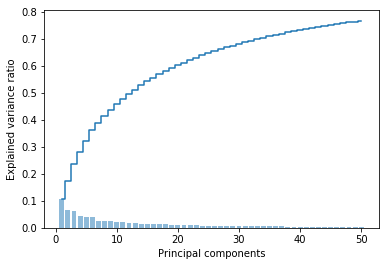

In [4]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

plt.bar(range(1, 51), pca.explained_variance_ratio_[0:50], alpha=0.5, align='center')
plt.step(range(1, 51), np.cumsum(pca.explained_variance_ratio_)[0:50], where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [6]:
import random
import math

class MyClassifier():
    def __init__(self, lr=0.1, max_iter=3000, mini_batch=50, lamda=0.01):
        self.lr=lr
        self.max_iter=max_iter
        self.w = []
        self.w_avg = []
        self.b = []
        self.mini_batch = mini_batch
        self.lamda = lamda
        for i in range(10):
            self.w.append([])
            self.w_avg.append([])
            self.w_avg[i] = np.zeros(1275)
            self.b.append(random.random())
            for j in range(1275):
                self.w[i].append(random.random())
        self.w = np.array(self.w)
        self.w_avg = np.array(self.w_avg)
        self.y_pred = []
        self.batch= []
        self.x_poly = np.zeros(1275)
    def fit(self, X, y):
        self.batch= []
        for i in range(len(X)):
            self.batch.append(i)
        self.batch = np.array(self.batch)
        np.random.shuffle(self.batch)
        for c in range(10):
            index = 0
            for k in range(self.max_iter):
                tem_w = 0
                tem_b = 0
                for i in range(self.mini_batch):
                    r = self.batch[index]
                    tem_w = tem_w + self.delta_w(X,y,r,c)
                    tem_b = tem_b + self.delta_b(X,y,r,c)
                    index = index+1
                    if(index>=len(X)):
                        index=0
                tem_w = tem_w/self.mini_batch
                tem_b = tem_b/self.mini_batch
                self.w[c] = self.w[c] - self.lr*tem_w
                self.b[c] = self.b[c] - self.lr*tem_b
                if(k>=500):
                    self.w_avg[c] = self.w_avg[c] + self.w[c]
                if(k%500==0):
                    print("class: ",c," iter: ",k)
            self.w_avg[c] = self.w_avg[c]/(self.max_iter-500)
            self.w[c] = self.w_avg[c]
        return self
    def predict(self, X):
        for k in X:
            self.y_pred.append(self.classify(k))
        self.y_pred = np.reshape(self.y_pred,(-1))
        for i in self.y_pred:
            print(i);
        return self.y_pred
    def get_params(self, deep=True):
        return {'lr'==self.lr}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    def dot(self,w,x):
        return sum(w_i*x_i for w_i,x_i in zip(w,x))
    def f_wb(self,X,y_,r,c):
        self.x_poly = self.poly(X[r])
        return (1-y_*(self.dot(self.w[c],self.x_poly)+self.b[c]))
    def delta_w(self,X,y,r,c):
        if(y[r]==c):
            y_=1
        else:
            y_=-1
        if(self.f_wb(X,y_,r,c) >= 0):
            return -1*y_*np.reshape(self.x_poly,(-1,1275)) + self.lamda*self.w[c]
        else:
            return self.lamda*self.w[c]
    def delta_b(self,X,y,r,c):
        if(y[r]==c):
            y_=1
        else:
            y_=-1
        if(self.f_wb(X,y_,r,c) >= 0):
            return -1*y_
        else:
            return 0
    def classify(self,X):
        max_ = 0
        index = 0
        self.x_poly = self.poly(X)
        for c in range(10):
            dis = self.dot(self.w[c],self.x_poly)+self.b[c]
            if(dis > max_):
                max_ = dis
                index = c
        return index
    def poly(self,X):
        X_poly = []
        for i in range(50):
            X_poly.append(X[i])
        for i in range(49):
            for j in range(i+1,50):
                X_poly.append(X[i] * X[j])
        return X_poly

In [7]:
start_time = time.time()
svm = MyClassifier()
svm.fit(X_train_pca, y_train)
fit_exec_time= time.time()
print("--- Fit execution:  %s seconds ---" % (fit_exec_time - start_time))
y_pred = svm.predict(X_test_pca)
predict_exec_time = time.time()-fit_exec_time
print("--- Prediction execution:  %s seconds ---" % predict_exec_time)
print('Accuracy: %f' % accuracy_score(y_test, y_pred))

class:  0  iter:  0
class:  0  iter:  500
class:  0  iter:  1000
class:  0  iter:  1500
class:  0  iter:  2000
class:  0  iter:  2500
class:  1  iter:  0
class:  1  iter:  500
class:  1  iter:  1000
class:  1  iter:  1500
class:  1  iter:  2000
class:  1  iter:  2500
class:  2  iter:  0
class:  2  iter:  500
class:  2  iter:  1000
class:  2  iter:  1500
class:  2  iter:  2000
class:  2  iter:  2500
class:  3  iter:  0
class:  3  iter:  500
class:  3  iter:  1000
class:  3  iter:  1500
class:  3  iter:  2000
class:  3  iter:  2500
class:  4  iter:  0
class:  4  iter:  500
class:  4  iter:  1000
class:  4  iter:  1500
class:  4  iter:  2000
class:  4  iter:  2500
class:  5  iter:  0
class:  5  iter:  500
class:  5  iter:  1000
class:  5  iter:  1500
class:  5  iter:  2000
class:  5  iter:  2500
class:  6  iter:  0
class:  6  iter:  500
class:  6  iter:  1000
class:  6  iter:  1500
class:  6  iter:  2000
class:  6  iter:  2500
class:  7  iter:  0
class:  7  iter:  500
class:  7  iter:  10

9
7
7
5
1
1
2
1
9
9
9
1
0
2
0
2
1
1
4
6
9
1
5
4
9
7
7
0
5
6
2
6
2
8
0
6
9
5
0
9
7
7
1
4
8
5
3
4
3
4
7
7
5
0
2
4
8
8
1
5
3
9
5
9
7
6
9
0
3
6
3
9
8
2
2
1
2
8
6
8
5
0
3
9
4
9
2
5
1
5
1
0
4
1
4
4
3
3
9
1
2
2
3
3
0
2
9
0
0
9
7
6
0
9
3
7
8
4
1
9
0
7
2
7
9
9
0
9
5
1
1
8
7
5
1
9
5
3
5
4
9
5
9
5
1
9
0
9
7
5
4
9
2
0
1
0
5
1
4
9
3
3
6
1
5
2
5
2
2
0
0
2
6
6
0
1
2
0
3
0
2
3
0
7
9
0
0
0
8
9
5
0
3
2
5
9
0
8
8
4
6
8
8
4
5
4
8
5
4
9
2
2
1
2
6
8
8
7
0
3
6
6
4
3
8
8
7
2
2
0
0
9
3
9
9
1
9
8
6
6
4
2
6
9
2
8
5
4
5
7
9
9
9
2
1
8
3
4
0
3
8
7
9
3
4
6
5
6
2
3
9
2
6
0
0
0
1
2
8
7
9
8
2
0
4
7
7
5
0
5
6
4
6
7
4
3
0
7
5
0
7
4
2
6
8
9
9
4
2
4
6
7
8
7
6
9
4
1
3
7
3
0
8
7
2
6
1
3
9
2
2
9
2
1
8
3
2
9
6
8
4
0
1
2
8
4
5
2
7
8
1
1
3
0
3
5
7
0
3
1
9
3
5
3
1
7
7
3
0
8
4
8
2
6
2
2
9
7
3
9
0
9
9
6
4
2
9
7
2
1
1
6
7
9
7
5
9
6
8
2
1
2
4
5
7
6
1
3
2
5
9
9
3
6
1
1
4
6
9
7
2
1
5
1
4
6
3
4
1
1
0
8
1
6
8
4
9
0
7
3
0
4
9
0
6
6
0
3
6
7
7
2
8
6
0
8
3
0
2
9
8
3
2
5
3
9
8
0
0
1
9
5
1
3
9
6
0
1
4
1
7
1
2
3
7
9
7
4
9
9
3
9
2
8
2
7
1
3
0
9


1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
3
5
3
2
9
3
2
1
4
5
5
2
3
2
1
3
9
7
2
1
2
8
9
1
8
8
7
8
1
0
0
6
7
7
8
7
5
0
6
1
5
7
4
6
1
2
5
0
7
9
9
0
3
4
4
8
4
1
8
6
5
9
0
0
0
3
7
1
6
4
6
0
4
5
4
1
3
8
6
3
9
9
5
9
3
7
8
5
6
4
7
6
2
2
0
9
4
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
6
4
2
6
4
7
5
5
4
7
2
9
3
9
3
8
2
0
9
5
6
0
1
0
6
5
3
5
3
8
0
0
3
4
1
5
3
0
8
3
0
6
2
7
8
1
7
1
3
8
5
4
2
0
9
7
6
7
4
1
6
2
6
7
1
9
8
0
6
9
4
9
9
6
2
3
7
1
9
2
2
5
3
7
8
0
1
2
3
4
7
8
9
0
1
2
3
4
7
8
9
0
1
7
8
9
8
9
2
6
1
3
5
4
8
2
6
4
3
4
5
9
2
0
3
9
4
9
7
3
8
7
4
4
9
8
5
8
2
6
6
2
3
1
3
2
7
3
1
9
0
1
1
3
5
0
7
8
1
5
1
4
6
0
0
4
9
1
6
6
9
0
7
6
1
1
0
1
2
3
4
2
8
3
4
5
6
2
0
1
2
2
8
6
3
9
2
1
9
3
9
6
1
7
2
4
4
5
2
0
0
1
6
6
8
2
7
2
8
4
2
1
6
1
0
6
7
8
3
9
6
3
0
1
2
3
4
5
6
7
8
9
0
8
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
1
6
8
9
9
0
1
2
4
4
3
7
4
4
4
0
3
8
7
5
8
2
1
7
5
3
8
5
2
5
1
1
6
2
1
3
8
6
4
2
6
2
5
5
0
2
8
0
6
8
1
7
9
1
9
2
6
7
6
6
8
7
4
9
2
1
3
3
0
5
5
8
0
3
7
9
7
0
2
7
9
1


5
3
6
0
0
3
1
6
0
0
2
2
5
0
3
3
5
4
3
8
8
8
0
0
0
4
5
1
4
0
3
6
4
0
1
9
5
6
3
4
0
2
0
2
3
1
0
4
6
7
7
0
7
2
1
4
1
6
8
7
1
8
7
4
1
0
3
6
8
4
4
3
2
8
0
8
9
9
7
2
6
7
0
5
4
3
1
0
6
1
8
9
4
0
1
6
2
8
6
5
7
9
1
5
9
6
8
0
0
0
6
7
9
7
4
9
9
9
9
7
6
7
0
8
3
4
7
9
0
2
2
1
5
1
3
7
7
0
8
6
0
4
1
3
2
1
2
8
4
9
0
6
6
1
7
2
8
2
7
0
0
2
1
5
2
9
3
2
4
4
5
1
6
0
7
3
8
7
9
0
0
1
1
9
2
4
3
6
4
6
5
5
6
0
7
5
8
8
9
7
6
5
2
8
6
9
5
0
4
1
8
2
0
0
2
0
1
2
7
0
1
2
8
8
3
7
7
0
1
1
7
1
1
2
4
9
4
0
5
6
7
6
4
9
9
7
7
2
2
8
6
3
5
5
2
2
9
1
9
8
0
2
8
6
1
2
9
6
0
3
6
7
5
7
0
8
4
0
6
2
3
6
7
6
0
1
1
1
4
8
8
0
0
1
1
0
2
1
9
8
3
0
1
6
4
5
2
8
9
0
8
2
2
9
8
4
6
8
9
0
2
4
9
7
6
6
3
1
3
0
6
7
3
0
1
5
2
0
5
0
0
1
3
1
1
1
5
2
0
6
9
7
0
3
0
0
9
0
0
2
1
6
2
9
3
7
4
8
5
4
6
8
7
0
8
0
8
0
0
5
1
0
2
8
3
6
4
9
5
0
6
3
0
5
8
1
9
1
0
1
1
1
2
6
0
7
4
5
5
6
6
2
7
0
8
8
9
2
6
6
1
6
9
9
9
3
9
2
4
4
4
8
3
4
0
0
1
0
4
0
1
6
6
6
5
4
0
0
8
9
5
1
3
7
0
9
4
5
9
1
1
7
9
4
4
0
4
3
1
3
8
1
7
6
6
2
0
0
8
8
1
6
8
1
8
3
6
3
0
0
0
1
7
1
1
9
8
1
5
5


6
5
0
8
8
3
4
9
0
0
4
1
1
6
0
0
6
3
6
8
0
0
1
2
2
6
0
8
4
4
6
7
0
3
4
9
0
1
1
4
2
3
8
3
4
5
5
3
4
3
7
7
0
6
0
8
0
0
1
6
2
5
7
8
0
8
6
5
7
8
4
1
0
4
7
2
2
3
9
8
4
5
2
9
9
2
8
0
4
3
5
7
8
1
2
3
0
8
5
5
5
4
4
6
0
8
3
6
4
9
6
1
5
0
1
8
7
2
8
1
4
0
5
3
7
6
2
3
8
4
6
0
5
3
7
9
7
7
7
1
6
3
0
2
1
0
0
6
1
3
6
3
5
6
3
6
1
0
4
6
7
7
6
3
2
9
2
2
5
1
9
0
1
4
2
4
2
2
7
1
9
6
0
6
9
2
0
0
0
5
0
0
8
6
0
6
0
2
7
1
5
6
8
6
6
4
1
4
4
5
0
2
0
3
6
3
0
3
0
2
8
3
8
8
1
0
3
0
1
0
0
5
9
8
0
0
1
2
2
4
3
6
5
7
6
0
7
4
8
1
0
0
1
9
2
2
3
0
4
0
5
8
6
4
7
0
8
0
0
3
1
5
2
0
3
6
4
4
5
3
6
3
7
4
5
2
9
0
8
4
3
3
7
2
0
4
1
4
7
7
3
9
0
1
9
2
4
6
5
3
2
0
0
7
6
0
2
1
1
5
1
5
1
7
7
1
2
6
4
4
2
3
9
6
7
9
0
5
0
3
7
0
5
6
1
1
1
0
6
6
1
0
8
2
2
7
7
6
4
0
0
5
4
3
2
0
5
0
0
2
3
0
1
4
8
6
1
0
1
6
0
0
6
8
9
0
3
2
0
0
8
6
3
7
9
8
6
5
3
9
0
6
1
9
4
1
5
3
6
8
7
8
8
3
3
7
0
5
1
7
2
8
0
6
0
2
5
6
6
5
7
3
8
4
0
7
1
0
2
1
3
1
4
1
5
8
6
9
7
4
8
2
0
6
1
1
6
0
0
6
9
9
9
1
0
9
1
8
2
1
1
5
2
3
9
0
7
6
4
3
2
4
1
9
0
9
3
8
8
6
0
0
5
5
1
7
5
1
8
0


In [16]:
test = list(read("10k", "."))
test_ = list(read("D2","."))
x_test = []
y_test = []
for i in range(len(test)):
    x_test.append(test[i][1][4:24,4:24])
    y_test.append(test[i][0])
for i in range(len(test_)):
    x_test.append(test_[i][1][4:24,4:24])
    y_test.append(test_[i][0])
x_test = np.reshape(x_test,(-1,400))
y_test = np.reshape(y_test, -1)

for x in x_test:
    for i in range(400):
        if(x[i] > 0):
            x[i] = 255
X_test_std = sc.transform(x_test)
X_test_pca = pca.transform(X_test_std)
svm.y_pred = []
y_pred = svm.predict(X_test_pca)

E:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


5
0
4
1
9
2
1
3
1
4
3
5
3
6
1
7
2
8
8
1
4
0
9
1
2
2
4
3
7
7
3
8
6
9
0
5
6
0
7
6
1
0
1
9
3
9
8
5
3
3
3
0
7
9
0
8
0
9
4
1
4
4
6
0
4
5
6
1
0
0
1
7
1
6
3
0
2
1
1
9
0
0
2
6
7
8
3
9
0
4
6
9
4
6
8
0
7
8
3
1
5
7
1
7
1
1
6
3
0
2
9
3
1
1
0
4
9
2
0
0
2
0
2
7
1
8
6
4
1
6
3
4
1
9
0
3
3
0
0
4
3
7
4
2
8
5
8
6
4
3
7
6
1
9
9
6
0
3
7
2
8
2
9
4
4
6
4
9
8
0
9
2
7
5
1
5
9
1
0
3
1
3
3
9
1
7
6
2
8
2
0
5
0
7
4
9
7
8
3
2
1
1
0
3
6
1
0
3
1
0
0
1
1
2
7
3
0
4
6
5
2
6
4
7
2
0
9
9
3
0
7
1
0
2
3
3
5
4
6
5
8
6
3
7
0
8
0
8
1
0
3
1
2
2
3
3
6
4
7
5
0
6
2
7
4
8
5
9
0
1
1
4
4
5
6
4
1
2
5
3
9
3
9
0
3
9
6
5
7
4
1
3
4
0
4
8
0
4
3
6
8
7
6
0
9
7
5
7
2
1
1
6
8
9
4
1
3
2
2
9
0
3
9
6
7
2
0
3
5
4
3
6
5
8
9
5
4
7
4
2
0
3
4
8
9
1
3
2
8
7
8
1
8
7
1
1
3
1
1
0
2
3
0
4
4
2
1
6
8
4
1
7
4
4
9
2
0
7
2
4
6
2
1
9
7
2
8
7
6
9
2
2
3
8
1
6
5
1
1
0
2
6
4
5
8
3
1
5
1
7
2
7
4
4
0
8
1
5
5
8
0
6
7
9
0
3
7
0
9
0
6
6
2
3
9
0
7
5
4
8
0
9
0
1
2
8
7
1
2
6
1
0
3
0
1
1
8
0
0
0
9
4
0
5
0
6
1
7
7
8
1
9
2
0
5
1
2
2
7
3
5
4
9
7
1
0
3
0
6
0
3
1
1
2
0
3
5
0
6
8


3
3
1
6
6
0
9
5
7
7
4
9
3
0
0
1
2
0
5
1
2
7
6
9
0
0
8
2
9
6
4
5
3
4
5
7
4
6
8
5
1
0
5
4
9
3
0
9
6
3
4
8
6
0
8
1
1
6
4
0
7
1
3
2
7
2
2
2
2
8
0
1
0
0
1
3
7
6
7
2
4
2
0
6
8
2
8
0
9
7
6
3
8
1
8
9
2
7
3
0
6
8
1
0
2
0
7
0
8
0
9
3
5
1
2
8
6
8
2
6
4
5
8
2
4
1
6
2
5
6
0
2
1
2
2
0
3
9
4
2
5
6
7
7
2
5
0
4
1
6
2
7
3
3
4
0
3
3
2
8
7
0
9
0
7
0
0
1
1
5
2
9
2
0
4
4
7
5
2
7
1
1
6
1
8
4
9
6
9
1
0
7
1
0
2
6
4
1
4
4
3
7
7
5
4
9
4
1
4
3
0
7
3
4
0
4
7
6
5
4
8
8
2
7
1
3
7
1
4
0
1
2
1
9
6
6
2
5
1
6
2
9
8
9
6
6
4
9
0
7
4
0
2
3
4
4
4
7
6
0
2
5
5
2
3
8
0
6
2
0
9
0
0
2
6
7
8
8
1
8
7
3
1
7
6
3
7
0
6
1
0
4
7
7
4
3
0
2
3
6
3
1
5
6
0
7
0
4
3
0
7
9
9
4
7
3
7
1
9
9
1
7
6
0
7
1
0
6
0
9
1
3
0
8
3
0
4
1
5
6
6
1
7
0
8
7
7
6
0
9
1
6
2
9
3
2
4
5
5
1
5
1
4
7
8
5
8
1
0
4
1
4
7
3
8
2
4
1
5
0
6
3
0
3
8
3
5
1
1
1
9
5
9
1
7
1
1
6
0
0
9
7
0
2
3
3
9
0
0
8
1
0
7
3
2
1
2
7
3
9
6
1
8
1
0
9
2
0
3
1
3
7
0
2
9
6
0
1
6
8
1
9
7
6
5
3
8
1
3
0
4
8
8
3
6
4
5
6
8
0
8
9
0
4
4
0
7
8
1
0
0
1
8
5
1
1
7
5
5
4
9
4
2
5
3
7
4
6
6
0
1
0
1
3
4
8
0
3
5
6


5
7
2
1
0
4
5
3
5
1
4
8
6
8
1
6
4
7
1
2
8
7
7
2
5
7
5
0
1
3
0
3
7
9
1
1
3
1
6
3
3
1
3
3
2
4
2
1
6
1
9
4
9
4
6
3
3
3
3
0
1
9
1
7
6
5
5
3
6
8
0
5
1
9
9
0
7
2
6
7
4
6
3
3
9
0
0
2
7
0
7
2
9
1
0
7
0
1
3
3
7
2
9
5
3
0
0
0
2
5
0
6
1
8
0
3
1
0
0
6
4
6
3
4
1
3
7
0
4
0
7
2
9
4
2
7
0
4
6
0
2
2
6
7
2
8
0
9
9
3
0
8
0
1
1
2
2
5
3
7
4
0
5
0
6
4
7
1
8
0
8
9
0
9
1
0
2
9
3
0
4
1
5
8
6
3
7
7
8
5
9
2
0
2
1
2
2
3
3
2
4
0
5
9
6
3
7
2
8
0
9
8
7
8
4
1
3
6
8
5
5
6
1
1
8
0
5
6
2
0
8
3
6
5
1
6
9
6
2
0
4
0
0
5
9
2
9
6
3
2
7
8
7
0
9
2
1
0
8
0
2
1
7
8
5
9
8
3
5
2
3
8
2
7
2
1
0
5
5
0
8
2
6
3
0
8
5
3
0
7
3
6
8
0
1
4
0
3
3
4
0
7
4
1
7
7
4
7
9
0
2
6
9
2
1
9
2
5
5
8
7
1
1
3
7
1
1
7
6
1
7
2
3
0
3
5
6
8
5
4
6
0
2
0
8
1
0
6
6
1
4
3
9
0
8
3
0
4
2
4
9
1
6
8
5
6
5
2
9
4
5
8
3
7
7
8
4
5
3
1
6
2
0
2
0
0
6
9
9
8
0
2
1
3
1
4
3
0
2
4
1
8
0
4
0
0
1
7
2
0
3
7
4
0
5
8
6
9
0
7
2
1
0
4
1
4
9
0
9
0
6
9
0
1
5
9
7
3
4
9
6
6
5
4
0
7
4
0
1
3
1
3
6
7
2
7
1
0
1
1
7
4
1
3
5
1
2
4
4
6
3
5
5
6
0
4
1
9
5
7
8
0
2
7
4
6
4
3
0
7
0
2
0
1
7
3
2
9
7
7


7
6
1
3
2
5
9
9
3
6
1
1
4
6
9
7
2
1
5
1
4
6
3
4
1
1
0
8
1
6
8
4
9
0
7
3
0
4
9
0
6
6
0
3
6
7
7
2
8
6
0
8
3
0
2
9
8
3
2
5
3
9
8
0
0
1
9
5
1
3
9
6
0
1
4
1
7
1
2
3
7
9
7
4
9
9
3
9
2
8
2
7
1
3
0
9
1
0
1
7
7
9
6
9
9
9
2
1
6
1
3
5
2
1
9
7
6
4
5
7
6
1
9
9
6
3
6
2
9
8
1
2
2
5
5
2
3
7
2
1
0
1
0
4
5
2
0
2
8
3
5
1
7
8
1
1
2
9
7
8
4
0
0
0
7
0
8
4
7
7
8
5
8
6
9
8
1
3
8
0
3
1
7
0
5
5
1
6
5
7
4
9
3
5
4
7
1
2
0
8
1
6
0
7
3
9
7
8
9
6
0
8
6
4
8
7
7
9
3
8
6
9
7
2
3
4
0
2
1
0
5
5
5
7
2
4
6
7
2
8
3
0
8
7
8
4
0
8
4
4
5
8
5
6
6
3
0
9
3
7
6
8
9
3
4
9
5
8
9
1
2
8
8
6
8
1
3
7
9
0
1
1
9
7
0
8
1
7
4
5
7
1
2
1
1
3
0
6
3
1
2
6
0
7
6
6
9
3
1
0
5
2
2
0
5
4
3
8
4
6
6
2
7
9
5
1
3
2
4
3
6
1
9
4
4
7
6
5
4
1
9
9
2
7
8
0
1
3
6
1
3
4
1
1
1
5
6
0
7
0
7
3
3
2
5
7
2
9
4
9
8
1
3
1
6
1
2
7
4
0
0
0
8
2
2
9
2
2
1
9
9
2
7
5
1
3
4
9
4
1
7
5
6
2
8
3
1
2
8
4
9
9
7
7
0
7
7
1
3
2
4
0
3
9
9
8
4
1
0
6
0
9
6
8
6
1
1
9
8
9
2
3
5
5
9
4
2
1
9
4
3
9
6
0
4
0
6
0
1
2
3
4
7
8
9
0
1
2
3
4
7
8
9
0
1
2
3
4
5
6
7
8
9
8
3
4
7
8
6
2
1
0
9
7
1
9
3
8
4
7


7
2
2
3
9
3
3
5
5
0
7
3
5
6
5
1
4
1
1
2
8
2
6
1
5
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
8
0
6
0
0
2
3
7
9
4
7
1
9
1
7
1
4
0
0
1
7
5
7
1
3
5
3
1
6
9
7
1
3
0
2
6
0
8
9
0
3
5
4
8
1
5
9
2
6
6
3
8
1
4
7
5
2
0
0
1
7
8
7
4
8
8
2
3
6
1
0
9
5
2
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
0
6
7
8
9
0
1
2
3
4
6
6
7
8
9
7
0
6
1
4
0
9
5
3
7
1
0
7
5
8
6
3
2
2
0
5
5
6
0
3
8
1
0
3
0
0
7
4
9
0
9
0
7
1
7
1
6
6
5
6
0
5
7
6
4
9
9
5
3
7
4
3
0
0
6
6
1
1
3
2
1
0
0
1
2
3
4
7
8
4
0
1
8
3
4
5
6
7
8
0
1
2
3
4
7
8
9
0
8
3
9
5
1
8
6
8
4
1
7
1
7
3
5
6
9
1
1
1
2
1
2
0
7
7
5
8
2
5
8
1
7
3
4
6
8
7
0
4
8
7
7
5
4
3
4
2
8
1
5
1
0
2
3
3
6
7
0
6
8
0
3
9
7
8
8
7
7
1
0
1
7
8
9
0
1
2
9
4
5
6
7
8
0
1
2
3
4
7
8
9
7
8
6
4
1
9
5
8
4
4
7
0
1
9
2
8
7
8
2
6
0
6
5
3
5
8
9
1
4
0
6
1
0
0
6
2
1
1
7
7
8
4
6
0
7
0
3
6
8
7
1
5
2
4
9
4
2
6
4
1
7
2
6
6
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6


In [17]:
print('Accuracy: %f' % accuracy_score(y_test, y_pred))

Accuracy: 0.895150
